<a href="https://colab.research.google.com/github/nbht98/attack_cat_or_dog_classification/blob/master/TEST_SYNTHETIC_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install mia

In [0]:
# Import library 
import numpy as np

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data


In [0]:
NUM_CLASSES = 10
WIDTH = 32
HEIGHT = 32
CHANNELS = 3

TARGET_EPOCHS = 300 # Number of epochs to train target and shadow models
ATTACK_EPOCHS = 50 # Number of epochs to train attack models.
NUM_SHADOWS = 3 # Number of epochs to train attack models.

In [0]:
def get_data():
    """Prepare CIFAR10 data."""
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")
    y_train = y_train.astype("float32")
    y_test = y_test.astype("float32")
    X_train /= 255
    X_test /= 255
    return (X_train, y_train), (X_test, y_test)


In [0]:
def target_model_fn():
  """The architecture of the target (victim) model.
  The attack is white-box, hence the attacker is assumed to know this architecture too."""

  model = tf.keras.models.Sequential()

  model.add(
      layers.Conv2D(
          32,
          (3, 3),
          activation="relu",
          padding="same",
          input_shape=(WIDTH, HEIGHT, CHANNELS),
      )
  )
  model.add(layers.Conv2D(32, (3, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
  model.add(layers.Conv2D(64, (3, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
  model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model


def attack_model_fn():
  """Attack model that takes target model predictions and predicts membership.
  Following the original paper, this attack model is specific to the class of the input.
  AttachModelBundle creates multiple instances of this model for each class.
  """
  model = tf.keras.models.Sequential()

  model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

  model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
  model.add(layers.Dense(64, activation="relu"))

  model.add(layers.Dense(1, activation="sigmoid"))
  model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
  return model


In [19]:
(X_train, y_train), (X_test, y_test) = get_data()

170500096/170498071 [==============================] - 13s 0us/step


In [6]:
# Train the target model.
print("Training the target model...")
target_model = target_model_fn()
target_model.load_weights("model900.h5")

Training the target model...


In [0]:
target_model.fit(
    X_train, y_train, epochs=TARGET_EPOCHS, validation_split=0.1, verbose=True
)

Epoch 1/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2448 - accuracy: 0.9216 - val_loss: 0.8413 - val_accuracy: 0.8072
Epoch 2/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2450 - accuracy: 0.9225 - val_loss: 0.8545 - val_accuracy: 0.8016
Epoch 3/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2306 - accuracy: 0.9266 - val_loss: 0.8969 - val_accuracy: 0.7968
Epoch 4/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2427 - accuracy: 0.9241 - val_loss: 0.9124 - val_accuracy: 0.8002
Epoch 5/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2463 - accuracy: 0.9226 - val_loss: 0.9072 - val_accuracy: 0.8098
Epoch 6/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2384 - accuracy: 0.9257 - val_loss: 0.9480 - val_accuracy: 0.8036
Epoch 7/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2552 - accuracy: 0.9222 - val_loss: 0.8429 - val_ac

In [0]:
target_model.save('model900.h5')

In [0]:
X_train[0].shape

(32, 32, 3)

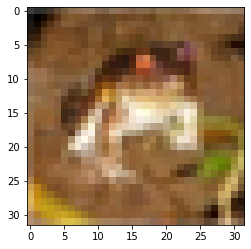

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.squeeze(X_train[0]))


In [0]:
def rand_array(x, k, in_channels, img_size):
    total_num = in_channels * img_size * img_size
    x = x.reshape(1, -1)
    idx_to_modify = np.random.randint(low=0, high=total_num-1, size=(k,))
    gen = np.random.rand(k)
    x[0, idx_to_modify] = gen
    x = x.reshape(img_size, img_size, in_channels)
    return x

In [0]:
def data_synthesize(target_model, fixed_cls, k_max,
                    in_channels, img_size):
    x = np.random.rand(32,32,3)

    y_c_current = 0         # target models probability of fixed class
    j = 0                   # consecutive rejections counter
    k = k_max               # search radius
    max_iter = 50           # max iter number
    conf_min = 0.1          # min probability cutoff to consider a record member of the class
    rej_max = 5             # max number of consecutive rejections
    k_min = 1               # min radius of feature perturbation

    for i in range(max_iter):
        y = target_model.predict(x.reshape(1,32,32,3))  # query target model
        y_c = y.flat[fixed_cls]
        # Phase 1: Search
        if y_c >= y_c_current:
            # Phase 2: Sample
            if (y_c > conf_min) and (fixed_cls == np.argmax(y)):
                return (x, y)
            x_new = x
            y_c_current = y_c  # renew variables
            j = 0
        else:
            j += 1
            if j > rej_max:  # many consecutive rejects
                k = max(k_min, int(np.ceil(k / 2)))
                j = 0
        x_tmp = rand_array(x_new, k, in_channels, img_size)
    return False

In [0]:
while True:
  data = data_synthesize(target_model, fixed_cls=8, k_max=3*32*32-1,
                    in_channels=3, img_size=32)
  if isinstance(data, tuple):
    break
 
print("########## Example ##########")
print("x = ", data[0])
print("y_c = ", data[1])



########## Example ##########
x =  [[[0.87030517 0.36670874 0.99370053]
  [0.03292683 0.75035519 0.52377042]
  [0.65738298 0.95304089 0.34246418]
  ...
  [0.60801636 0.95314409 0.99947137]
  [0.55357325 0.29511688 0.51255932]
  [0.14015186 0.18017607 0.46853886]]

 [[0.65602958 0.3720002  0.40533345]
  [0.98971155 0.41983007 0.93460038]
  [0.31496371 0.31231365 0.87940248]
  ...
  [0.67411246 0.57053958 0.6926034 ]
  [0.39059735 0.41604357 0.64047795]
  [0.98156937 0.68212393 0.16545752]]

 [[0.52881334 0.84204207 0.44925571]
  [0.47431053 0.63119915 0.88575371]
  [0.73238839 0.75934742 0.69482466]
  ...
  [0.29396462 0.90136557 0.47366653]
  [0.74607701 0.94568164 0.32200293]
  [0.06344505 0.58446541 0.82577534]]

 ...

 [[0.77696568 0.69817245 0.7248345 ]
  [0.64101937 0.66422237 0.86225392]
  [0.09669618 0.58567491 0.63742678]
  ...
  [0.48680858 0.65647618 0.56691183]
  [0.28430026 0.32299729 0.83720629]
  [0.81698808 0.04719099 0.69213978]]

 [[0.36327176 0.17791454 0.68737012]
  

In [0]:
from numpy import savetxt
def synthesize_batch(target_model, lst_class, n_records):
    """
    Synthesize a batch of records
    """
    x_synth = np.zeros((n_records,32,32,3))
    y_synth = np.zeros((n_records, 10))
    count = 0
    for i in range(n_records//10):
      for j in lst_class:
        while True:
            data = data_synthesize(target_model, fixed_cls=j, k_max=3*32*32-1,
                          in_channels=3, img_size=32)
            if isinstance(data, tuple):
                break
      
        x_synth[count] = data[0]
        y_synth[count] = data[1]
        count += 1
      if (i % 9 == 0):
          np.savez('data' + str(i) +'.npz', x=data[0], y=data[1])
          print('data'+ str(i) +' has been saved')
    return x_synth, y_synth

In [0]:
attack1 = synthesize_batch(target_model, [0,1,2,3,4,5,6,7,8,9], 100)

0
0 1 2 3 4 5 6 7 8 9 
1
0 1 2 3 4 5 6 7 8 9 
2
0 1 2 3 4 5 6 7 8 9 
3
0 1 2 3 4 5 6 7 8 9 
4
0 1 2 3 4 5 6 7 8 9 
5
0 1 2 3 4 5 6 7 8 9 
6
0 1 2 3 4 5 6 7 8 9 
7
0 1 2 3 4 5 6 7 8 9 
8
0 1 2 3 4 5 6 7 8 9 
9
0 1 2 3 4 5 6 7 8 9 


In [0]:
from numpy import load 
aa = np.load('data.npz')

In [47]:
attack3 = synthesize_batch(target_model, [0,1,2,3,4,5,6,7,8,9], 900)

data0 has been saved









data9 has been saved









data18 has been saved









data27 has been saved









data36 has been saved









data45 has been saved









data54 has been saved









data63 has been saved









data72 has been saved









data81 has been saved











In [79]:
# We assume that attacker's data were not seen in target's training.
# attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
#     X_test, y_test, test_size=0.1
# )

# We assume that attacker's data were not seen in target's training.
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    np.concatenate((attack2[0][:800], attack3[0]),axis=0), np.concatenate((attack2[1][:800], attack3[1]),axis=0), test_size=0.1
)
print(attacker_X_train.shape, attacker_X_test.shape)

(1530, 32, 32, 3) (170, 32, 32, 3)


In [0]:
SHADOW_DATASET_SIZE = 750

# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=NUM_SHADOWS,
)

In [81]:
print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=900,
        verbose=True,
        validation_data=(attacker_X_test, attacker_y_test),
    ),
)

Streaming output truncated to the last 5000 lines.
24/24 [==============================] - 0s 6ms/step - loss: 1.5287 - accuracy: 0.7640 - val_loss: 2.3192 - val_accuracy: 0.1059
Epoch 202/900
24/24 [==============================] - 0s 6ms/step - loss: 1.5186 - accuracy: 0.7733 - val_loss: 2.3189 - val_accuracy: 0.0765
Epoch 203/900
24/24 [==============================] - 0s 6ms/step - loss: 1.5168 - accuracy: 0.7653 - val_loss: 2.3059 - val_accuracy: 0.0941
Epoch 204/900
24/24 [==============================] - 0s 6ms/step - loss: 1.5240 - accuracy: 0.7907 - val_loss: 2.3241 - val_accuracy: 0.0882
Epoch 205/900
24/24 [==============================] - 0s 6ms/step - loss: 1.5254 - accuracy: 0.7520 - val_loss: 2.3219 - val_accuracy: 0.0882
Epoch 206/900
24/24 [==============================] - 0s 6ms/step - loss: 1.5111 - accuracy: 0.7493 - val_loss: 2.3306 - val_accuracy: 0.1118
Epoch 207/900
24/24 [==============================] - 0s 6ms/step - loss: 1.5260 - accuracy: 0.7560 - va

In [82]:
# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(
    X_shadow, y_shadow, fit_kwargs=dict(epochs=20, verbose=True)
)

Training the attack models...
Epoch 1/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.7314
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.5631 - accuracy: 0.8930
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.3771 - accuracy: 0.9214
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.2048 - accuracy: 0.9541
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.1224 - accuracy: 0.9585
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0892 - accuracy: 0.9716
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0744 - accuracy: 0.9694
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0778 - accuracy: 0.9738
Epoch 9/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9738
Epoch 10/20
15/15 [==============================] - 0s 2ms/step - loss: 0.0633 - accura

In [83]:
# Test the success of the attack.
ATTACK_TEST_DATASET_SIZE = 4000
# Prepare examples that were in the training, and out of the training.
data_in = X_train[:ATTACK_TEST_DATASET_SIZE], y_train[:ATTACK_TEST_DATASET_SIZE]
data_out = X_test[:ATTACK_TEST_DATASET_SIZE], y_test[:ATTACK_TEST_DATASET_SIZE]
# data_out = np.concatenate((X_test, a_X_train), axis=0), np.concatenate((y_test, a_y_train), axis=0)


# Compile them into the expected format for the AttackModelBundle.
attack_test_data, real_membership_labels = prepare_attack_data(
    target_model, data_in, data_out
)

# Compute the attack accuracy.
attack_guesses = amb.predict(attack_test_data)
attack_accuracy = np.mean(attack_guesses == real_membership_labels)
print(attack_accuracy)


0.535625
